In [26]:
!git clone --depth 1 --branch main https://github.com/gilbutITbook/080289/chap06/data/dogs-vs-cats.git


Cloning into 'dogs-vs-cats'...
remote: Not Found
fatal: repository 'https://github.com/gilbutITbook/080289/chap06/data/dogs-vs-cats.git/' not found


### 라이브러리 호출

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import time

import cv2
from torch.utils.data import DataLoader, Dataset
from PIL import Image

device = torch.device('cuda' if  torch.cuda.is_available() else 'cpu')

In [2]:
# Namedtuple 이란?

Student = namedtuple('Student', ['name', 'age', 'DOB']) # 네임드튜플 정의
S = Student('홍길동', '19', '187') # 네임드튜플에 값을 추가
print(S[1]) # 인덱스로 접근
print(S.name) # 키로 접근

19
홍길동


### 이미지 데이터 전처리

In [3]:
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale = (0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]), # train 전처리
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]), # val, test 전처리
        }

    def __call__(self, img, phase):
        return self.data_transform[phase](img)

In [4]:
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

### 데이터셋 불러오기 & 데이터셋 분리

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
cat_directory = r'/content/Cat'
dog_directory = r'/content/080289/chap06/data/dogs-vs-cats/Dog'

cat_images_filepaths = sorted([os.path.join(cat_directory, f) for f in os.listdir(cat_directory)])
dog_images_filepaths = sorted([os.path.join(dog_directory, f) for f in os.listdir(dog_directory)])

images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

In [33]:
random.seed(42)
random.shuffle(correct_images_filepaths)
train_images_filepaths = correct_images_filepaths[:400]
val_images_filepaths = correct_images_filepaths[400:-10]
test_images_filepaths = correct_images_filepaths[-10:]
print(len(train_images_filepaths), len(val_images_filepaths),
      len(test_images_filepaths))

400 92 10


In [37]:
# 이미지에 대한 레이블 구분
class DogvsCatDataset(Dataset):
    def __init__(self, file_list, transform = None, phase = 'train'):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img, self.phase)

        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0
        return img_transformed, label

In [38]:
# 이미지 데이터셋 정의
train_dataset = DogvsCatDataset(train_images_filepaths, transform = ImageTransform(size, mean, std), phase = 'train')
val_dataset = DogvsCatDataset(val_images_filepaths, transform = ImageTransform(size, mean, std), phase = 'val')

# index 0의 이미지 크기와 레이블에 대한 출력
index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 224, 224])
1


In [39]:
# 데이터셋의 데이터를 메모리로 불러오기
train_iterator = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
valid_iterator = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)
dataloader_dict = {'train': train_iterator, 'val': valid_iterator}

# batch_iterator = iter(train_iterator)
inputs, label = next(iter(train_iterator))
print(inputs.size())
print(label)

torch.Size([32, 3, 224, 224])
tensor([1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 0, 0, 1, 1])


### 기본 블록 정의

In [40]:
from re import I
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=False):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride=stride, padding=1, bias=False) # 3x3 Conv

        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, kernel_size = 3, stride=stride, padding=1, bias=False) # 3x3 Conv

        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace = True)

        # downsampling: 입력 데이터와 출력 데이터 크기 다를 때 사용
        # stride로 다운 샘플 적용
        if downsample:
            conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1, stride=stride, bias=False)
            bn = nn.BatchNorm2d(out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
        self.downsample = downsample

    def forward(self, x):
        i = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)

        if self.downsample is not None:
            i = self.downsample(i)

        x+= I # identitiy mapping(skip connection)
        x = self.relu(x)

### Bottlenect 블록 정의

In [41]:
class Bottleneck(nn.Module):
    expansion = 4 # bottleneck block 정의를 위한 hyperparameter

    def __init__(self, in_channels, out_channels, stride=1, downsample=False):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False) # 1x1 conv

        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False) # 3x3 conv

        self.bn2 = nn.BatchNorm2d(out_channels)
        # 1x1 conv, 또한 다음 계층의 입력 채널 수와 일치하도록 expansion * out_channels 진행
        self.conv3 = nn.Conv2d(out_channels, self.expansion*out_channels, kernel_size=1, stride=1, bias = False)

        self.bn3 = nn.BatchNorm2d(self.expansion*out_channels)
        self.relu = nn.ReLU(inplace=True)

        if downsample:
            conv = nn. Conv2d(in_channels, self.expansion*out_channels, kernel_size=1, stride=stride, bias=False)
            bn = nn.BatchNorm2d(self.expansion*out_channels)
            downsample = nn. Sequential(conv, bn)
        else:
            downsample = None
        self.downsample = downsample

    def forward(self, x):
        i = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.downsample is not None:
            i = self.downsample(i)

        x += i
        x = self.relu(x)
        return x

### ResNet 모델 네트워크

In [42]:
class ResNet(nn.Module):
    def __init__(self, config, output_dim, zero_init_residual = False):
        super().__init__()

        block, n_blocks, channels = config # resnet을 호출할 때 넘겨준 config 값들을 block, n_blocks, channels에 저장
        self.in_channels = channels[0]
        assert len(n_blocks) == len(channels) == 4 # 블록 크기 = 채널 크기 = 4

        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn. ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1])
        self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2])
        self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3])

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)

        # 각 residual branch에 있는 마지막 BN을 0으로 초기화해서 다음 residual branch를 0에서 시작할 수 있게 함
        # BN을 0으로 초기화 할 경우 모델 성능이 0.2~0.3% 향상
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def get_resnet_layer(self, block, n_blocks, channels, stride=1): # 블록을 추가하기 위한 함수
        layers = []
        if self.in_channels != block.expansion * channels: # channel 수 다르면 downsample 적용
            downsample = True
        else:
            downsample = False

        # layer를 추가할 때 in_channels, channels, stride 뿐만 아니라 downsample 여부도 같이 전달
        layers.append(block(self.in_channels, channels, stride, downsample))
        for i in range(1, n_blocks):
            layers.append(block(block.expansion*channels, channels))

        self.in_channels = block.expansion * channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x) # 224x224
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x) # 112x112
        x = self.layer1(x) # 56x56
        x = self.layer2(x) # 28x28
        x = self.layer3(x) # 14x14
        x = self.layer4(x) # 7x7
        x = self.avgpool(x) # 1x1
        h = x.view(x.shape[0], -1)
        x = self.fc(h)
        return x, h

### ResNetConfig 정의

In [43]:
ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])

In [44]:
# 기본 블록을 사용해 ResNetConfig 정의
resnet18_config = ResNetConfig(block = BasicBlock,
                               n_blocks=[2,2,2,2],
                               channels=[64,128,256,512])

resnet34_config = ResNetConfig(block = BasicBlock,
                               n_blocks=[3,4,6,3],
                               channels=[64,128,256,512])

In [45]:
# 보틀넥 블록을 사용하여 ResNetConfig 정의
resnet50_config = ResNetConfig(block = Bottleneck,
                               n_blocks=[3,4,6,3],
                               channels=[64,128,256,512])

resnet101_config = ResNetConfig(block = Bottleneck,
                               n_blocks=[3,4,23,3],
                               channels=[64,128,256,512])

resnet152_config = ResNetConfig(block = Bottleneck,
                               n_blocks=[3,8,36,3],
                               channels=[64,128,256,512])

### Pre-trained ResNet 모델 사용

In [46]:
pretrained_model = models.resnet50(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 214MB/s]


In [47]:
print(pretrained_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### ResNet50 Config를 사용한 ResNet 모델 사용

In [48]:
OUTPUT_DIM = 2 # 두 개의 class
model = ResNet(resnet50_config, OUTPUT_DIM)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### 옵티마이저, 손실 함수 정의

In [49]:
optimizer = optim.Adam(model.parameters(), lr=1e-7)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

### 모델 학습 정확도 측정 함수 정의

In [50]:
def calculate_topk_accuracy(y_pred, y, k=2):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1) # torch.argmax와 같은 효과, 주어진 텐서에서 가장 큰 값의 index 반환
        top_pred = top_pred.t() # 차원 0과 1을 transpose(전치)
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred)) # torch.eq: 텐서 비교 함수, 서로 같은지 비교
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim=True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_k

### 모델 학습 함수 정의

In [51]:
def train(model, iterator, optimizer, criterion, scheduler, device):
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0

    model.train()

    for (x, y) in iterator:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred[0], y)

        acc_1, acc_5 = calculate_topk_accuracy(y_pred[0], y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item() # 모델의 첫 번째로 예측한 레이블
        epoch_acc_5 += acc_5.item() # 이미지에 정확한 레이블이 붙여질 것이라 정확도 100%

    scheduler.step()

    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
    return epoch_loss, epoch_acc_1, epoch_acc_5

### 모델 평가 함수 정의

In [52]:
def evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0

    model.eval()

    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)
            loss = criterion(y_pred[0], y)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred[0], y)
            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()

        epoch_loss /= len(iterator)
        epoch_acc_1 /= len(iterator)
        epoch_acc_5 /= len(iterator)
        return epoch_loss, epoch_acc_1, epoch_acc_5

### 모델 학습 시간 측정 함수 정의

In [53]:
def epoch_time(start_time, end_time):
    elasped_time = end_time - start_time
    elasped_mins = int(elasped_time/60)
    elasped_secs = int(elasped_time-(elasped_mins*60))
    return elasped_mins, elasped_secs

### 모델 학습

In [54]:
import torch
torch.cuda.empty_cache()

In [59]:
best_valid_loss = float('inf')
EPOCHS = 50

for epoch in range(EPOCHS):
    start_time = time.monotonic()

    train_loss, train_acc_1, train_acc_5 = train(model, train_iterator, optimizer,
                                                 criterion, scheduler, device)
    val_loss, val_acc_1, val_acc_5 = evaluate(model, valid_iterator,
                                                 criterion, device)

    if val_loss < best_valid_loss:
        best_valid_loss = best_valid_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/ResNet-model.pt')

    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')

    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | '
        f'Train Acc @5: {train_acc_5*100:6.2f}%')

    print(f'\tValid Loss: {val_loss:.3f} | Valid Acc @1: {val_acc_1*100:6.2f}% | '
        f'Valid Acc @5: {val_acc_5*100:6.2f}%')


Epoch: 01 | Epoch Time: 0m 19s
	Train Loss: 0.770 | Train Acc @1:  51.68% | Train Acc @5: 100.00%
	Valid Loss: 0.716 | Valid Acc @1:  44.05% | Valid Acc @5: 100.00%
Epoch: 02 | Epoch Time: 0m 19s
	Train Loss: 0.765 | Train Acc @1:  51.68% | Train Acc @5: 100.00%
	Valid Loss: 0.782 | Valid Acc @1:  44.05% | Valid Acc @5: 100.00%
Epoch: 03 | Epoch Time: 0m 19s
	Train Loss: 0.750 | Train Acc @1:  52.88% | Train Acc @5: 100.00%
	Valid Loss: 0.819 | Valid Acc @1:  44.05% | Valid Acc @5: 100.00%
Epoch: 04 | Epoch Time: 0m 19s
	Train Loss: 0.747 | Train Acc @1:  52.64% | Train Acc @5: 100.00%
	Valid Loss: 0.828 | Valid Acc @1:  44.05% | Valid Acc @5: 100.00%
Epoch: 05 | Epoch Time: 0m 19s
	Train Loss: 0.757 | Train Acc @1:  51.44% | Train Acc @5: 100.00%
	Valid Loss: 0.829 | Valid Acc @1:  44.05% | Valid Acc @5: 100.00%
Epoch: 06 | Epoch Time: 0m 19s
	Train Loss: 0.755 | Train Acc @1:  50.96% | Train Acc @5: 100.00%
	Valid Loss: 0.817 | Valid Acc @1:  44.05% | Valid Acc @5: 100.00%
Epoch: 07 

KeyboardInterrupt: 

### 테스트 데이터셋을 이용한 모델 예측

In [64]:
import pandas as pd

id_list = []
pred_list = []

with torch.no_grad():
    for test_path in test_images_filepaths:
        img = Image.open(test_path)
        _id = test_path.split('/')[-1].split('.')[1]  # 파일명에서 ID 추출
        transform = ImageTransform(size, mean, std)
        img = transform(img, phase='val')
        img = img.unsqueeze(0)
        img = img.to(device)

        model.eval()
        outputs = model(img)
        preds = F.softmax(outputs[0], dim=1)[:, 1].tolist()

        id_list.append(_id)
        pred_list.append(preds[0])

res = pd.DataFrame({
    'id': id_list,
    'label': pred_list
})

res.sort_values(by='id', inplace=True)
res.reset_index(drop=True, inplace=True)

res.to_csv('/content/drive/MyDrive/ResNet.csv', index=False)
res.head(10)

,id,label
0,133,0.555538
1,137,0.579322
2,155,0.634653
3,17,0.573508
4,176,0.599529
5,19,0.632071
6,224,0.646948
7,57,0.538420
8,78,0.587309
9,91,0.569153


### 모델 예측에 대한 결과 출력

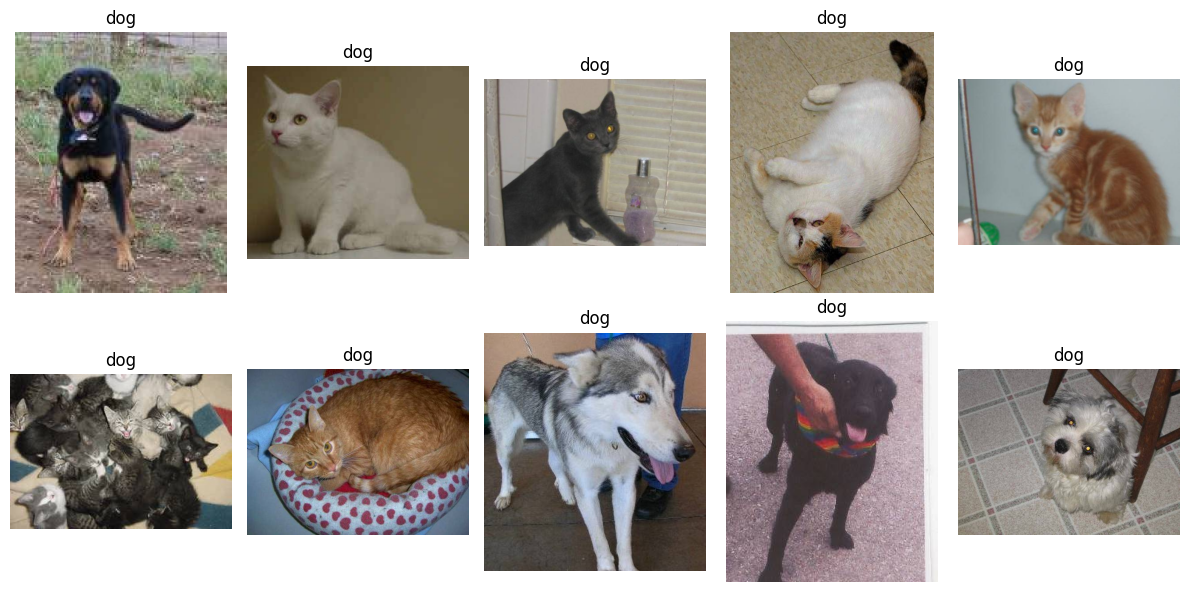

In [65]:
classes = {0: 'cat', 1: 'dog'}

def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))

    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        a = random.choice(res['id'].values)
        label = res.loc[res['id'] == a, 'label'].values[0]

        if label > 0.5:
            label = 1
        else:
            label = 0

        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(classes[label])
        ax.ravel()[i].set_axis_off()

    plt.tight_layout()
    plt.show()

display_image_grid(test_images_filepaths)


굉장히 거지같은 정확도!

### ResNet CIFAR-10 Dataset (Github 코드)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# ResNet의 기본 구성 요소인 Bottleneck 블록 정의
class Bottleneck(nn.Module):
    expansion = 4  # 출력 채널을 증가시키는 계수 (ResNet50, 101, 152에서 사용)

    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()

        # 1x1 컨볼루션 (채널 축소)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)

        # 3x3 컨볼루션 (특징 학습)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        # 1x1 컨볼루션 (채널 확장)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels * self.expansion)

        self.i_downsample = i_downsample  # 입력 크기를 조정하는 경우 (stride!=1 또는 채널 mismatch)
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = x.clone()  # 스킵 연결을 위한 원본 입력 복사

        x = self.relu(self.batch_norm1(self.conv1(x)))  # 1x1 conv -> BN -> ReLU
        x = self.relu(self.batch_norm2(self.conv2(x)))  # 3x3 conv -> BN -> ReLU
        x = self.batch_norm3(self.conv3(x))  # 1x1 conv -> BN (ReLU 없음)

        # 다운샘플링 필요하면 identity에 적용
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)

        x += identity  # 스킵 연결 (Residual Connection)
        x = self.relu(x)  # 최종 활성화 함수 적용
        return x


# ResNet-18, 34에서 사용되는 기본 블록 (Bottleneck 대신 사용됨)
class Block(nn.Module):
    expansion = 1  # 기본 블록에서는 채널 확장이 없음

    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Block, self).__init__()

        # 3x3 컨볼루션 레이어 2개 (stride는 첫 번째에서 적용)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.i_downsample = i_downsample  # 입력 크기 맞추기 위한 다운샘플링
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = x.clone()  # 스킵 연결을 위한 원본 데이터 복사

        x = self.relu(self.batch_norm2(self.conv1(x)))  # 3x3 conv -> BN -> ReLU
        x = self.batch_norm2(self.conv2(x))  # 3x3 conv -> BN

        # 다운샘플링 필요하면 적용
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)

        print(x.shape)  # 디버깅용 출력
        print(identity.shape)  # 디버깅용 출력

        x += identity  # 스킵 연결
        x = self.relu(x)  # 최종 활성화 적용
        return x


# ResNet 모델 정의
class ResNet(nn.Module):
    def __init__(self, ResBlock, layer_list, num_classes, num_channels=3):
        super(ResNet, self).__init__()
        self.in_channels = 64  # 처음 입력 채널 설정

        # 초기 컨볼루션 레이어 (7x7 커널, stride=2, padding=3)
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # 3x3 MaxPooling (stride=2)

        # ResNet 레이어 구성 (각 블록 개수 설정)
        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=256, stride=2)
        self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # 1x1로 평균 풀링
        self.fc = nn.Linear(512 * ResBlock.expansion, num_classes)  # 최종 FC 레이어

    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))  # 초기 컨볼루션 적용
        x = self.max_pool(x)  # MaxPooling 적용

        x = self.layer1(x)  # 첫 번째 ResNet 블록
        x = self.layer2(x)  # 두 번째 ResNet 블록
        x = self.layer3(x)  # 세 번째 ResNet 블록
        x = self.layer4(x)  # 네 번째 ResNet 블록

        x = self.avgpool(x)  # Global Average Pooling 적용
        x = x.reshape(x.shape[0], -1)  # Flatten 처리
        x = self.fc(x)  # Fully Connected Layer
        return x

    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []

        # 첫 번째 블록에서 stride가 2이거나, 채널 크기가 다르면 downsampling 적용
        if stride != 1 or self.in_channels != planes * ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes * ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes * ResBlock.expansion)
            )

        # 첫 번째 블록 (다운샘플링 적용 가능)
        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes * ResBlock.expansion  # 채널 크기 업데이트

        # 나머지 블록 추가
        for i in range(blocks - 1):
            layers.append(ResBlock(self.in_channels, planes))

        return nn.Sequential(*layers)


# ResNet50, 101, 152 모델 생성 함수
def ResNet50(num_classes, channels=3):
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes, channels)

def ResNet101(num_classes, channels=3):
    return ResNet(Bottleneck, [3, 4, 23, 3], num_classes, channels)

def ResNet152(num_classes, channels=3):
    return ResNet(Bottleneck, [3, 8, 36, 3], num_classes, channels)


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [ ]:
train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

trainloader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True, num_workers=2)

test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

testloader = torch.utils.data.DataLoader(test, batch_size=128,shuffle=False, num_workers=2)

100%|██████████| 170M/170M [02:17<00:00, 1.24MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
net = ResNet50(10).to('cuda')

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience=5)

In [ ]:
EPOCHS = 200
for epoch in range(EPOCHS):
    losses = []
    running_loss = 0
    for i, inp in enumerate(trainloader):
        inputs, labels = inp
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i%100 == 0 and i > 0:
            print(f'Loss [{epoch+1}, {i}](epoch, minibatch): ', running_loss / 100)
            running_loss = 0.0

    avg_loss = sum(losses)/len(losses)
    scheduler.step(avg_loss)

print('Training Done')

Loss [1, 100](epoch, minibatch):  7.8524831104278565
Loss [1, 200](epoch, minibatch):  3.4950244498252867
Loss [1, 300](epoch, minibatch):  2.556767237186432
Loss [2, 100](epoch, minibatch):  2.215501329898834
Loss [2, 200](epoch, minibatch):  2.0712103629112244
Loss [2, 300](epoch, minibatch):  2.0066441071033476
Loss [3, 100](epoch, minibatch):  1.8536076653003692
Loss [3, 200](epoch, minibatch):  1.8116028463840486
Loss [3, 300](epoch, minibatch):  1.7545536470413208
Loss [4, 100](epoch, minibatch):  1.6944678390026093
Loss [4, 200](epoch, minibatch):  1.6547881424427033
Loss [4, 300](epoch, minibatch):  1.6243597543239594
Loss [5, 100](epoch, minibatch):  1.5923947322368621
Loss [5, 200](epoch, minibatch):  1.56361359000206
Loss [5, 300](epoch, minibatch):  1.5369385695457458
Loss [6, 100](epoch, minibatch):  1.5213324785232545
Loss [6, 200](epoch, minibatch):  1.4920316815376282
Loss [6, 300](epoch, minibatch):  1.4661492455005645
Loss [7, 100](epoch, minibatch):  1.45942114830017

KeyboardInterrupt: 

In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to('cuda'), labels.to('cuda')
        outputs = net(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy on 10,000 test images: ', 100*(correct/total), '%')

Accuracy on 10,000 test images:  81.95 %


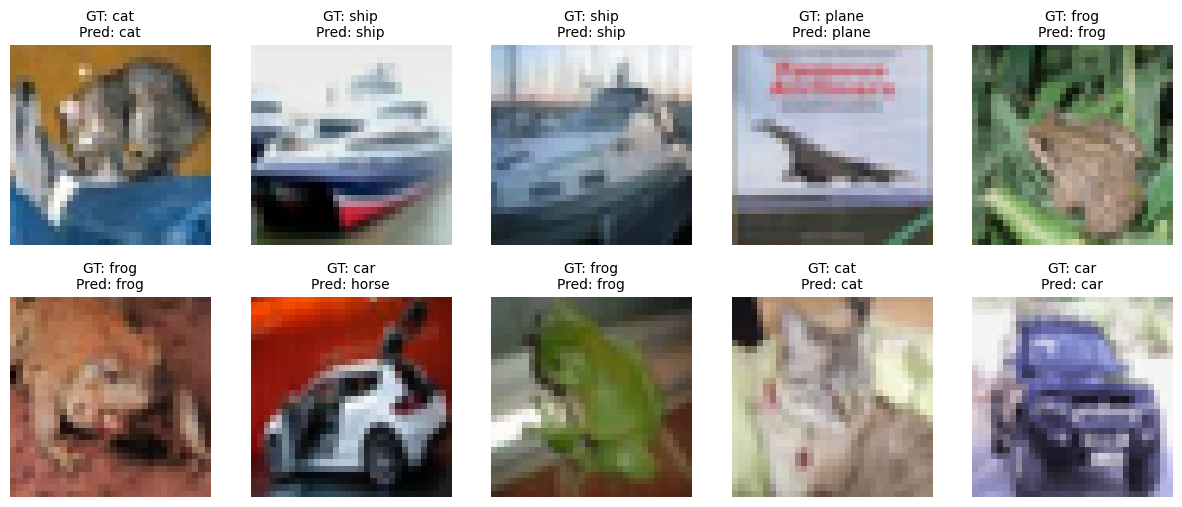

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # 정규화를 되돌리기
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

def visualize_test_samples(model, dataloader, classes, device='cuda'):
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for i in range(10):
        img = images[i].cpu().numpy()
        img = img / 2 + 0.5  # 정규화 해제
        img = np.transpose(img, (1, 2, 0))

        axes[i // 5, i % 5].imshow(img)
        axes[i // 5, i % 5].axis('off')
        axes[i // 5, i % 5].set_title(f'GT: {classes[labels[i]]}\nPred: {classes[predicted[i]]}', fontsize=10)

    plt.show()

visualize_test_samples(net, testloader, classes)